In [41]:
#Importing libraries and simple information extraction
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import(classification_report,roc_auc_score,average_precision_score, confusion_matrix, precision_recall_curve)

transaction = pd.read_csv('Transaction_dataset.csv')
transaction.head(10)

print('Original Shape:',transaction.shape)
print('\nColumns:',transaction.columns)
print('\n',transaction.dtypes)

Original Shape: (6362620, 11)

Columns: Index(['step', 'type', 'amount', 'nameOrig', 'oldbalanceOrg', 'newbalanceOrig',
       'nameDest', 'oldbalanceDest', 'newbalanceDest', 'isFraud',
       'isFlaggedFraud'],
      dtype='object')

 step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object


In [48]:
#Data Exploration & insights of fraudulent transactions
print('\nFraud cases [1] being fraud:')
print(transaction['isFraud'].value_counts())
print('\nFraud rate by %:')
print((transaction['isFraud'].value_counts(normalize=True) * 100).round(2))
transaction.groupby('isFraud')['amount'].describe()
print('\nCounts by type of fraud:')
print((transaction.groupby('type')['isFraud'].mean().sort_values(ascending=False)*100))
print('\nTransaction fraud filtering:',transaction.groupby(['type', 'isFraud']).size().unstack())




Fraud cases [1] being fraud:
isFraud
0    6354407
1       8213
Name: count, dtype: int64

Fraud rate by %:
isFraud
0    99.87
1     0.13
Name: proportion, dtype: float64

Counts by type of fraud:
type
TRANSFER    0.768799
CASH_OUT    0.183955
CASH_IN     0.000000
DEBIT       0.000000
PAYMENT     0.000000
Name: isFraud, dtype: float64

Transaction fraud filtering: isFraud           0       1
type                       
CASH_IN   1399284.0     NaN
CASH_OUT  2233384.0  4116.0
DEBIT       41432.0     NaN
PAYMENT   2151495.0     NaN
TRANSFER   528812.0  4097.0


In [ ]:
#Adding columns for feature engineering
transaction['original_balance'] = transaction['oldbalanceOrg'] - transaction['newbalanceOrig']
transaction['destination_balance'] = transaction['newbalanceOrig'] - transaction['oldbalanceOrg']


In [ ]:
#One-hot encode transaction type separately, define features (X) and target label (y), then move onto tesing and training 
#LogisticRegression as model
#transaction_model = pd.get_dummies(transaction,columns=['type'],drop_first=True) #make sure to take out the '#' and run once then put the '#' back in place

X = transaction.drop(columns = ['isFraud', 'isFlaggedFraud', 'nameOrig', 'nameDest','type'])
y = transaction['isFraud']
    
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,stratify=y,random_state=42)

pipeline = Pipeline([("scaler", StandardScaler()),("model", LogisticRegression(class_weight="balanced",max_iter=2000,random_state=42))])
pipeline.fit(X_train,y_train)

,"steps steps: list of tuplesList of (name of step, estimator) tuples that are to be chained insequential order. To be compatible with the scikit-learn API, all stepsmust define `fit`. All non-last steps must also define `transform`. See:ref:`Combining Estimators ` for more details.","[('scaler', ...), ('model', ...)]"
,"transform_input transform_input: list of str, default=NoneThe names of the :term:`metadata` parameters that should be transformed by thepipeline before passing it to the step consuming it.This enables transforming some input arguments to ``fit`` (other than ``X``)to be transformed by the steps of the pipeline up to the step which requiresthem. Requirement is defined via :ref:`metadata routing `.For instance, this can be used to pass a validation set through the pipeline.You can only set this if metadata routing is enabled, which youcan enable using ``sklearn.set_config(enable_metadata_routing=True)``... versionadded:: 1.6",None
,"memory memory: str or object with the joblib.Memory interface, default=NoneUsed to cache the fitted transformers of the pipeline. The last stepwill never be cached, even if it is a transformer. By default, nocaching is performed. If a string is given, it is the path to thecaching directory. Enabling caching triggers a clone of the transformersbefore fitting. Therefore, the transformer instance given to thepipeline cannot be inspected directly. Use the attribute ``named_steps``or ``steps`` to inspect estimators within the pipeline. Caching thetransformers is advantageous when fitting is time consuming. See:ref:`sphx_glr_auto_examples_neighbors_plot_caching_nearest_neighbors.py`for an example on how to enable caching.",None
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting each step will be printed as itis completed.",False
,"copy copy: bool, default=TrueIf False, try to avoid a copy and do inplace scaling instead.This is not guaranteed to always work inplace; e.g. if the data isnot a NumPy array or scipy.sparse CSR matrix, a copy may still bereturned.",True
,"with_mean with_mean: bool, default=TrueIf True, center the data before scaling.This does not work (and will raise an exception) when attempted onsparse matrices, because centering them entails building a densematrix which in common use cases is likely to be too large to fit inmemory.",True
,"with_std with_std: bool, default=TrueIf True, scale the data to unit variance (or equivalently,unit standard deviation).",True
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not wo

In [50]:
#Generate predictions and fraud probabilities on the test set
preds = pipeline.predict(X_test)
probs = pipeline.predict_proba(X_test)[:,1]

print('Classification Report:\n',classification_report(y_test,preds))
print('Confusion Matrix:\n',confusion_matrix(y_test,preds))
print("ROC AUC:", roc_auc_score(y_test,probs))
print('PR AUC:',average_precision_score(y_test,probs))


Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98   1270881
           1       0.03      0.88      0.06      1643

    accuracy                           0.96   1272524
   macro avg       0.51      0.92      0.52   1272524
weighted avg       1.00      0.96      0.98   1272524

Confusion Matrix:
 [[1224599   46282]
 [    205    1438]]
ROC AUC: 0.9744684356469894
PR AUC: 0.5486944157038001


In [28]:
#Tuning + results (focusing on recall)
precision, recall, thresholds = precision_recall_curve(y_test, probs)

t96 = thresholds[np.where(recall[:-1] >= 0.96)[0][-1]]  
preds_96 = (probs >= t96).astype(int)

print("Threshold for 96% recall:", t96)
print(confusion_matrix(y_test, preds_96))
print(classification_report(y_test, preds_96))


Threshold for 96% recall: 0.21058342753824916
[[1014138  256743]
 [     65    1578]]
              precision    recall  f1-score   support

           0       1.00      0.80      0.89   1270881
           1       0.01      0.96      0.01      1643

    accuracy                           0.80   1272524
   macro avg       0.50      0.88      0.45   1272524
weighted avg       1.00      0.80      0.89   1272524



In [ ]:
#Randomforest model + tuning + results for comparison
rf = RandomForestClassifier(n_estimators=50,max_depth=8,min_samples_leaf=100,n_jobs=-1,random_state=42)

rf.fit(X_train, y_train)

probs_rf = rf.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, probs_rf)
t97 = thresholds[np.where(recall[:-1] >= 0.97)[0][-1]]
preds_rf_97 = (probs_rf >= t97).astype(int)

print(confusion_matrix(y_test, preds_rf_97))
print(classification_report(y_test, preds_rf_97, digits=4))


[[1225017   45864]
 [     49    1594]]
              precision    recall  f1-score   support

           0     1.0000    0.9639    0.9816   1270881
           1     0.0336    0.9702    0.0649      1643

    accuracy                         0.9639   1272524
   macro avg     0.5168    0.9670    0.5233   1272524
weighted avg     0.9987    0.9639    0.9804   1272524



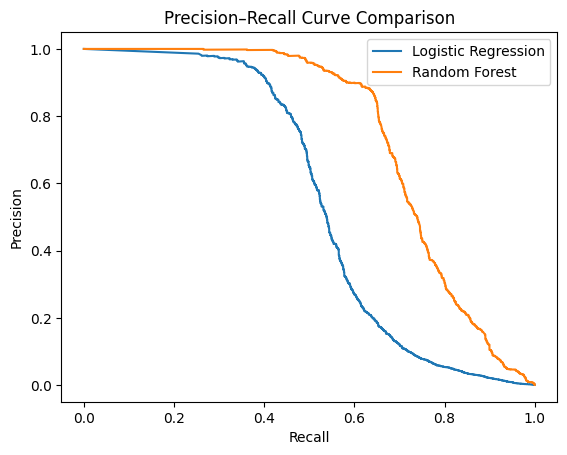

In [ ]:
#Precision-recall curve comparison between 2 models
probs_lr = pipeline.predict_proba(X_test)[:, 1]

precision_lr, recall_lr, _ = precision_recall_curve(y_test, probs_lr)
precision_rf, recall_rf, _ = precision_recall_curve(y_test, probs_rf)

plt.figure()
plt.plot(recall_lr, precision_lr, label="Logistic Regression")
plt.plot(recall_rf, precision_rf, label="Random Forest")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve Comparison")
plt.legend()
plt.show()


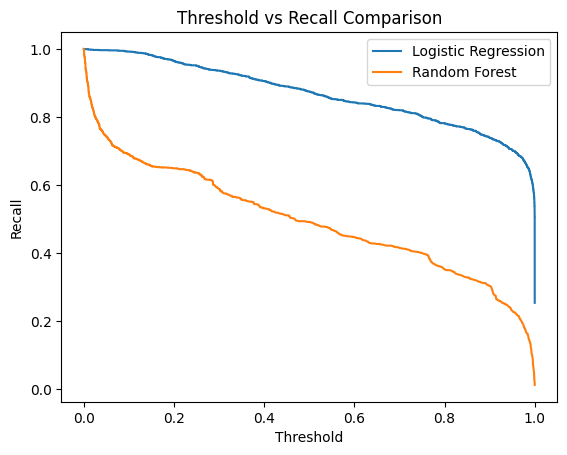

In [ ]:
#Threshold vs Recall comparison between 2 models
def threshold_recall_curve(y_true, probs):
    precision, recall, thresholds = precision_recall_curve(y_true, probs)
    return thresholds, recall[:-1]   # align recall with thresholds


thresholds_lr, recall_lr = threshold_recall_curve(y_test, probs_lr)
thresholds_rf, recall_rf = threshold_recall_curve(y_test, probs_rf)

plt.figure()
plt.plot(thresholds_lr, recall_lr, label="Logistic Regression")
plt.plot(thresholds_rf, recall_rf, label="Random Forest")
plt.xlabel("Threshold")
plt.ylabel("Recall")
plt.title("Threshold vs Recall Comparison")
plt.legend()
plt.show()
